<a href="https://colab.research.google.com/github/dookda/cmu_udfire_gee/blob/main/predict_hp_using_lstm_gee_colab.ipynb_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ติดตั้งไลบรารีที่จำเป็น
# !pip install geemap folium

# นำเข้าไลบรารีที่จำเป็น
import ee
import geemap
import folium
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math

In [3]:
# เริ่มต้นใช้งาน GEE
ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

In [4]:
# ฟังก์ชันคำนวณ NDVI จาก MOD09Q1
def calculate_ndvi(image):
    try:
        # MOD09Q1 bands: sur_refl_b01 (red), sur_refl_b02 (NIR)
        nir = image.select('sur_refl_b02').multiply(0.0001)  # Apply scale factor
        red = image.select('sur_refl_b01').multiply(0.0001)  # Apply scale factor

        # คำนวณ NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

        # กำหนดคุณสมบัติให้กับภาพ
        return image.addBands(ndvi).copyProperties(image, ['system:time_start'])
    except Exception as e:
        print(f"Error calculating NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล NDVI รายช่วง 8 วันจาก MOD09Q1
def get_8day_ndvi(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล MOD09Q1
        modis = ee.ImageCollection('MODIS/061/MOD09Q1') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)

        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = modis.size().getInfo()
        print(f"จำนวนภาพ MODIS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล MOD09Q1 ในพื้นที่ศึกษา")
            return None

        # คำนวณ NDVI
        modis_ndvi = modis.map(calculate_ndvi)
        print(f"จำนวนภาพหลังคำนวณ NDVI: {modis_ndvi.size().getInfo()}")

        # เฉลี่ย NDVI เป็นรายช่วง 8 วัน
        def create_8day_composite(start_millis):
            start = ee.Date(start_millis)
            end = start.advance(8, 'day')
            composite_collection = modis_ndvi.filterDate(start, end)
            count = composite_collection.size()

            # สร้างภาพเฉลี่ยและกำหนดคุณสมบัติ
            composite_mean = composite_collection.mean() \
                .set('system:time_start', start_millis) \
                .set('system:index', start.format('YYYY_MM_dd'))

            # ตรวจสอบว่ามีข้อมูลหรือไม่
            return ee.Algorithms.If(
                count.gt(0),
                composite_mean,
                ee.Image.constant(0).rename('NDVI') \
                    .set('system:time_start', start_millis) \
                    .set('system:index', start.format('YYYY_MM_dd'))
            )

        # สร้างรายการวันเริ่มต้นของแต่ละช่วง 8 วัน
        start_dates = ee.List.sequence(
            ee.Date(start_date).millis(),
            ee.Date(end_date).millis(),
            8 * 24 * 60 * 60 * 1000  # 8 วันในหน่วยมิลลิวินาที
        )

        # สร้าง ImageCollection
        composite_images = start_dates.map(create_8day_composite)
        composites_8day = ee.ImageCollection.fromImages(composite_images)

        print(f"จำนวนช่วง 8 วันทั้งหมด: {composites_8day.size().getInfo()}")

        return composites_8day.select('NDVI')
    except Exception as e:
        print(f"Error getting 8-day NDVI: {e}")
        return None

# ฟังก์ชันดึงข้อมูล Hotspot รายช่วง 8 วันจาก FIRMS - แก้ไขให้ดึง T21
def get_8day_hotspots(start_date, end_date, study_area):
    try:
        # เรียกชุดข้อมูล FIRMS
        firms = ee.ImageCollection('FIRMS') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area) \
            .select(['T21', 'confidence'])  # เลือกทั้งอุณหภูมิและความเชื่อมั่น

        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = firms.size().getInfo()
        print(f"จำนวนภาพ FIRMS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล FIRMS ในพื้นที่ศึกษา")
            return None

        # รวม hotspot เป็นรายช่วง 8 วัน
        def create_8day_hotspot_composite(start_millis):
            start = ee.Date(start_millis)
            end = start.advance(8, 'day')
            composite_collection = firms.filterDate(start, end)
            count = composite_collection.size()

            # คำนวณค่าเฉลี่ย T21 และจำนวน hotspot
            composite_mean = composite_collection.mean() \
                .set('system:time_start', start_millis) \
                .set('system:index', start.format('YYYY_MM_dd'))

            # เพิ่ม band สำหรับจำนวน hotspot
            hotspot_count_band = ee.Image.constant(count).rename('hotspot_count')
            composite_with_count = composite_mean.addBands(hotspot_count_band)

            return ee.Algorithms.If(
                count.gt(0),
                composite_with_count,
                ee.Image.constant([0, 0]).rename(['T21', 'hotspot_count']) \
                    .set('system:time_start', start_millis) \
                    .set('system:index', start.format('YYYY_MM_dd'))
            )

        # สร้างรายการวันเริ่มต้นของแต่ละช่วง 8 วัน
        start_dates = ee.List.sequence(
            ee.Date(start_date).millis(),
            ee.Date(end_date).millis(),
            8 * 24 * 60 * 60 * 1000  # 8 วันในหน่วยมิลลิวินาที
        )

        # สร้าง ImageCollection
        composite_images = start_dates.map(create_8day_hotspot_composite)
        composites_8day = ee.ImageCollection.fromImages(composite_images)

        print(f"จำนวนช่วง 8 วันที่มี hotspot: {composites_8day.size().getInfo()}")

        return composites_8day.select(['T21', 'hotspot_count'])
    except Exception as e:
        print(f"Error getting 8-day hotspots: {e}")
        return None

# ฟังก์ชันสร้างข้อมูลรวม - แก้ไขให้รวม T21 และ hotspot_count
def create_dataset(ndvi_collection, hotspot_collection, study_area):
    try:
        # ตรวจสอบว่ามีข้อมูลหรือไม่
        if ndvi_collection is None:
            print("ข้อมูล NDVI เป็น None")
            return None

        ndvi_size = ndvi_collection.size().getInfo()
        print(f"NDVI collection size: {ndvi_size}")

        if ndvi_size == 0:
            print("ไม่มีข้อมูล NDVI")
            return None

        # ใช้วันที่ของ NDVI เป็นหลัก
        ndvi_times = ndvi_collection.aggregate_array('system:time_start')
        print(f"จำนวนช่วงเวลาที่มีข้อมูล NDVI: {ndvi_times.size().getInfo()}")

        # ฟังก์ชันสำหรับรวมข้อมูลแต่ละช่วง 8 วัน
        def combine_8day_data(time_start):
            # กรองข้อมูล NDVI ตามเวลา
            ndvi_image = ndvi_collection.filter(ee.Filter.eq('system:time_start', time_start)).first()

            # หา hotspot ในช่วง 8 วันที่ตรงกับ NDVI
            start_date = ee.Date(time_start)
            end_date = start_date.advance(8, 'day')

            # ดึงข้อมูล FIRMS ในช่วงเวลาเดียวกับ NDVI
            firms_in_period = ee.ImageCollection('FIRMS') \
                .filterDate(start_date, end_date) \
                .filterBounds(study_area) \
                .select('T21')

            # คำนวณค่าเฉลี่ย T21 และนับจำนวน hotspot
            hotspot_count = firms_in_period.size()

            # สร้างภาพที่มี hotspot count และ mean T21
            mean_t21 = firms_in_period.mean()
            hotspot_count_image = ee.Image.constant(hotspot_count).rename('hotspot_count')

            # กำหนดค่าเริ่มต้นสำหรับ T21 ถ้าไม่มีข้อมูล
            mean_t21_filled = ee.Algorithms.If(
                hotspot_count.gt(0),
                mean_t21,
                ee.Image.constant(0).rename('T21')
            )

            # รวมภาพ
            combined_image = ndvi_image \
                .addBands(ee.Image(mean_t21_filled)) \
                .addBands(hotspot_count_image)

            # ลดขนาดข้อมูลเป็นค่าเฉลี่ยของพื้นที่ศึกษา
            reduced = combined_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=study_area,
                scale=1000,  # 1km resolution
                maxPixels=1e9
            )

            # สร้าง Feature พร้อมวันที่
            date_str = ee.Date(time_start).format('YYYY-MM-dd')
            return ee.Feature(None, reduced.set('date', date_str))

        # แปลงเป็น FeatureCollection โดยใช้เวลาของ NDVI
        if ndvi_times.size().getInfo() > 0:
            combined_fc = ee.FeatureCollection(ndvi_times.map(combine_8day_data))
            return combined_fc
        else:
            print("ไม่มีข้อมูล NDVI")
            return None

    except Exception as e:
        print(f"Error creating dataset: {e}")
        return None

# ฟังก์ชันแปลง FeatureCollection เป็น DataFrame - แก้ไขให้รองรับ T21
def fc_to_df(fc):
    try:
        # ดึงข้อมูลจาก GEE
        features = fc.getInfo()['features']
    except Exception as e:
        print("ไม่สามารถดึงข้อมูลจาก GEE ได้:", str(e))
        return pd.DataFrame()

    # สร้าง dictionary สำหรับเก็บข้อมูล
    data_dict = {'date': [], 'NDVI': [], 'T21': [], 'hotspot_count': []}

    for feature in features:
        props = feature['properties']
        if 'NDVI' in props and props['NDVI'] is not None:
            data_dict['date'].append(props.get('date', ''))
            data_dict['NDVI'].append(props.get('NDVI', 0))
            data_dict['T21'].append(props.get('T21', 0))
            data_dict['hotspot_count'].append(props.get('hotspot_count', 0))

    # สร้าง DataFrame
    df = pd.DataFrame(data_dict)

    # แปลงคอลัมน์ date เป็น datetime
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)

    return df

# ฟังก์ชันเตรียมข้อมูลสำหรับการฝึกแบบจำลอง - แก้ไขให้ใช้ T21 หรือ hotspot_count ได้
def prepare_training_data(df, sequence_length=4, target_column='T21'):
    # ตรวจสอบว่ามีข้อมูลหรือไม่
    if df.empty:
        raise ValueError("ไม่มีข้อมูลใน DataFrame")

    print(f"จำนวนข้อมูลดิบ: {len(df)}")
    print(f"คอลัมน์ที่มี: {df.columns.tolist()}")
    print(f"ตัวอย่างข้อมูล:\n{df.head()}")

    # ล้างข้อมูลที่ขาดหาย
    df_cleaned = df.fillna(0)  # เปลี่ยนจาก dropna() เป็น fillna(0)
    print(f"จำนวนข้อมูลหลังล้าง: {len(df_cleaned)}")
    print(f"ค่าสถิติพื้นฐาน:\n{df_cleaned.describe()}")

    # ตรวจสอบว่ามีข้อมูลเพียงพอหลังจากล้างข้อมูล
    min_required = sequence_length + 5
    if len(df_cleaned) < min_required:
        raise ValueError(f"ข้อมูลไม่เพียงพอสำหรับการสร้างลำดับ ต้องการอย่างน้อย {min_required} ข้อมูล แต่มีเพียง {len(df_cleaned)}")

    # ตรวจสอบคอลัมน์ที่มีอยู่และเลือกเป็น target
    available_targets = ['T21', 'hotspot_count']
    selected_target = None

    for target in available_targets:
        if target in df_cleaned.columns:
            selected_target = target
            print(f"ใช้ {target} เป็น target variable")
            break

    if selected_target is None:
        raise ValueError(f"ไม่พบคอลัมน์ target ใดๆ ในข้อมูล ตรวจสอบคอลัมน์ที่มี: {df_cleaned.columns.tolist()}")

    # เตรียมข้อมูล feature และ target
    feature_columns = ['NDVI']
    if selected_target == 'T21' and 'hotspot_count' in df_cleaned.columns:
        feature_columns.append('hotspot_count')
    elif selected_target == 'hotspot_count' and 'T21' in df_cleaned.columns:
        feature_columns.append('T21')

    X = df_cleaned[feature_columns].values
    y = df_cleaned[[selected_target]].values

    print(f"Features ที่ใช้: {feature_columns}")
    print(f"Target ที่ใช้: {selected_target}")

    # ปรับขนาดข้อมูล
    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # สร้างลำดับข้อมูลสำหรับ LSTM
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    print(f"จำนวนลำดับที่สร้างได้: {len(X_seq)}")
    print(f"รูปร่างข้อมูล X: {X_seq.shape}, y: {y_seq.shape}")

    # ไม่ต้อง reshape สำหรับ CNN อีกต่อไป - ใช้รูปร่างปกติสำหรับ LSTM
    return X_seq, y_seq, scaler_x, scaler_y

# ฟังก์ชันสร้างแบบจำลอง LSTM - เพิ่มฟังก์ชันที่ขาดหาย
def create_lstm_model(sequence_length, n_features):
    """สร้างแบบจำลอง LSTM สำหรับทำนาย hotspot"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam

        model = Sequential()

        # LSTM layers
        model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)))
        model.add(Dropout(0.2))

        model.add(LSTM(32, return_sequences=False))
        model.add(Dropout(0.2))

        # Output layer
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='mse',
                      metrics=['mae'])

        return model
    except ImportError:
        print("ไม่สามารถ import TensorFlow ได้ กรุณาติดตั้ง TensorFlow ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแบบจำลอง: {e}")
        return None

# ฟังก์ชันสร้างแบบจำลอง CNN-LSTM - ปรับปรุงสำหรับข้อมูลที่มีน้อย
def create_cnn_lstm_model(sequence_length, n_features):
    """สร้างแบบจำลอง CNN-LSTM สำหรับทำนาย hotspot"""
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam

        model = Sequential()

        # CNN layers - ใช้ Conv1D แทน Conv2D
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu',
                         input_shape=(sequence_length, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))

        # LSTM layers
        model.add(LSTM(32, return_sequences=False))
        model.add(Dropout(0.2))

        # Output layer
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='mse',
                      metrics=['mae'])

        return model
    except ImportError:
        print("ไม่สามารถ import TensorFlow ได้ กรุณาติดตั้ง TensorFlow ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแบบจำลอง CNN-LSTM: {e}")
        return None

# ฟังก์ชันประเมินผลแบบจำลอง
def evaluate_model(y_true, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')

    return mse, mae, r2

# ฟังก์ชันทำนาย hotspot สำหรับช่วง 8 วันถัดไป
def predict_next_8days(model, last_sequence, scaler_x, scaler_y):
    # ทำนาย
    prediction_scaled = model.predict(last_sequence)

    # แปลงกลับเป็นค่าปกติ
    prediction = scaler_y.inverse_transform(prediction_scaled)

    return prediction[0][0]

# ฟังก์ชันสร้างแผนที่ Folium
def create_prediction_map(prediction, study_area, date):
    try:
        import folium

        # สร้างแผนที่
        map_center = study_area.centroid().coordinates().getInfo()[::-1]
        m = folium.Map(location=map_center, zoom_start=10)

        # เพิ่ม layer พื้นที่ศึกษา
        study_area_geo = study_area.getInfo()
        folium.GeoJson(
            study_area_geo,
            name='Study Area',
            style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 2, 'fillOpacity': 0.1}
        ).add_to(m)

        # เพิ่มข้อความทำนาย
        prediction_text = f'Predicted Value for next 8 days ({date}): {prediction:.2f}'
        folium.Marker(
            location=map_center,
            icon=folium.DivIcon(
                html=f'<div style="font-size: 16pt; color: red; background-color: white; padding: 5px; border-radius: 5px;">{prediction_text}</div>'
            )
        ).add_to(m)

        return m
    except ImportError:
        print("ไม่สามารถ import folium ได้ กรุณาติดตั้ง folium ก่อน")
        return None
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการสร้างแผนที่: {e}")
        return None



กำลังดึงข้อมูล NDVI รายช่วง 8 วัน...
จำนวนภาพ MODIS ดิบ: 295
จำนวนภาพหลังคำนวณ NDVI: 295
จำนวนช่วง 8 วันทั้งหมด: 293
จำนวนช่วง 8 วันที่มีข้อมูล NDVI: 293
กำลังสร้างชุดข้อมูล...
NDVI collection size: 293
จำนวนช่วงเวลาที่มีข้อมูล NDVI: 293
กำลังแปลงข้อมูลเป็น DataFrame...
จำนวนข้อมูลใน DataFrame: 292
ตัวอย่างข้อมูล:
        date      NDVI         T21  hotspot_count
0 2018-01-01  0.429640         NaN              8
1 2018-01-09  0.711561  311.446213              8
2 2018-01-17  0.733592  315.999317              8
3 2018-01-25  0.712856  319.502396              8
4 2018-02-02  0.667996  315.940881              8
กำลังเตรียมข้อมูลสำหรับการฝึก...
จำนวนข้อมูลดิบ: 292
คอลัมน์ที่มี: ['date', 'NDVI', 'T21', 'hotspot_count']
ตัวอย่างข้อมูล:
        date      NDVI         T21  hotspot_count
0 2018-01-01  0.429640         NaN              8
1 2018-01-09  0.711561  311.446213              8
2 2018-01-17  0.733592  315.999317              8
3 2018-01-25  0.712856  319.502396              8
4 2018-02-

/Users/sakdahomhuan/miniforge3/envs/udfire/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


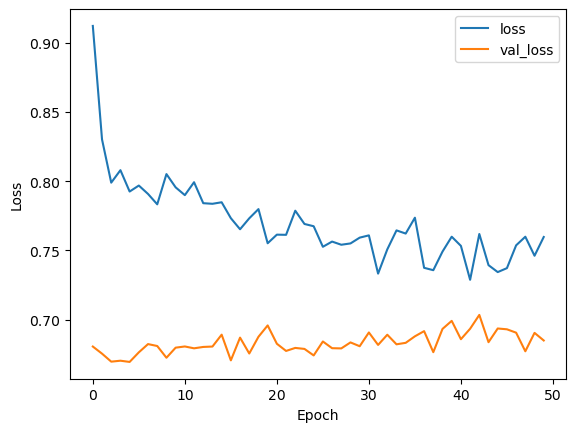

กำลังประเมินแบบจำลอง...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
ผลการประเมินแบบจำลอง:
MSE: 11162.2390
MAE: 77.9960
R²: 0.0730


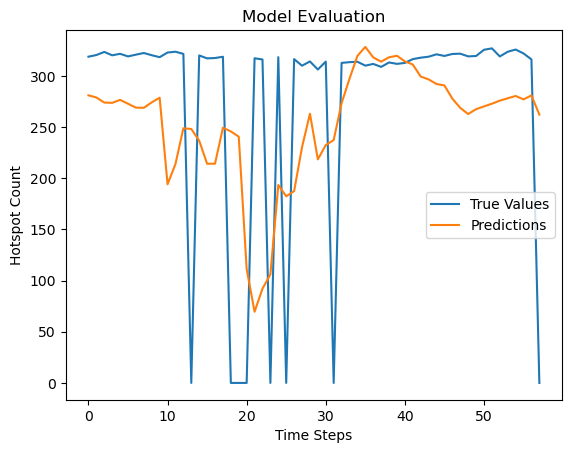

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
ทำนายสำหรับช่วง 8 วันถัดไป (2025-09-04): 262.10
เกิดข้อผิดพลาดในการเตรียมข้อมูล: x and y must have same first dimension, but have shapes (8,) and (1,)


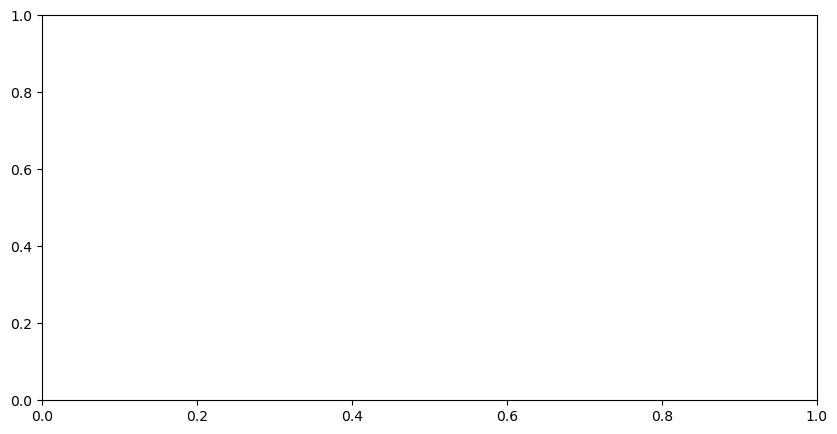

In [9]:

# กำหนดพื้นที่ศึกษาที่ใหญ่ขึ้น - ครอบคลุมภาคเหนือ
STUDY_AREA = ee.Geometry.Polygon(
    [[[98.0, 18.0],
    [100.0, 18.0],
    [100.0, 20.0],
    [98.0, 20.0],
    [98.0, 18.0]]])  # ขยายเป็น 2° x 2° ≈ 220x220 km

# กำหนดช่วงเวลาข้อมูล
start_date = '2018-01-01'
end_date = '2024-06-01'

print("กำลังดึงข้อมูล NDVI รายช่วง 8 วัน...")
ndvi_data = get_8day_ndvi(start_date, end_date, STUDY_AREA)

if ndvi_data is None:
    print("ไม่สามารถดึงข้อมูล NDVI ได้")
    # ขยายพื้นที่ศึกษา
    STUDY_AREA_EXPANDED = ee.Geometry.Polygon(
        [[[98.0, 18.0],
            [99.5, 18.0],
            [99.5, 19.5],
            [98.0, 19.5],
            [98.0, 18.0]]])
    print("ขยายพื้นที่ศึกษา")
    ndvi_data = get_8day_ndvi(start_date, end_date, STUDY_AREA_EXPANDED)
    study_area = STUDY_AREA_EXPANDED
else:
    study_area = STUDY_AREA

if ndvi_data is not None:
    print(f"จำนวนช่วง 8 วันที่มีข้อมูล NDVI: {ndvi_data.size().getInfo()}")

    print("กำลังสร้างชุดข้อมูล...")
    dataset = create_dataset(ndvi_data, None, study_area)  # ไม่ใช้ hotspot_data แยก

    if dataset is not None:
        print("กำลังแปลงข้อมูลเป็น DataFrame...")
        df = fc_to_df(dataset)
        print(f"จำนวนข้อมูลใน DataFrame: {len(df)}")

        if not df.empty and len(df) > 10:
            print("ตัวอย่างข้อมูล:")
            print(df.head())

            print("กำลังเตรียมข้อมูลสำหรับการฝึก...")
            try:
                X, y, scaler_x, scaler_y = prepare_training_data(df, sequence_length=4)
                print(f"ข้อมูลที่เตรียม: X.shape = {X.shape}, y.shape = {y.shape}")

                # แบ่งข้อมูลฝึกและทดสอบ
                split_idx = int(len(X) * 0.8)
                X_train, X_test = X[:split_idx], X[split_idx:]
                y_train, y_test = y[:split_idx], y[split_idx:]

                print(f"ข้อมูลฝึก: {X_train.shape}, ข้อมูลทดสอบ: {X_test.shape}")

                # สร้างและฝึกแบบจำลอง
                print("กำลังสร้างแบบจำลอง...")
                # ใช้ LSTM model
                model = create_lstm_model(X_train.shape[1], X_train.shape[2])

                if model is None:
                    print("ไม่สามารถสร้างแบบจำลองได้ กรุณาตรวจสอบการติดตั้ง TensorFlow")
                    raise RuntimeError("Model creation failed. Please check TensorFlow installation.")

                # หรือใช้ CNN-LSTM model
                # model = create_cnn_lstm_model(X_train.shape[1], X_train.shape[2])

                print("กำลังฝึกแบบจำลอง...")
                history = model.fit(
                    X_train, y_train,
                    epochs=50,
                    batch_size=8,  # ลด batch size
                    validation_data=(X_test, y_test) if len(X_test) > 0 else None,
                    verbose=0
                )

                # แสดงกราฟการฝึก
                import matplotlib.pyplot as plt

                plt.plot(history.history['loss'], label='loss')
                plt.plot(history.history['val_loss'], label='val_loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()

                # ประเมินแบบจำลอง
                if len(X_test) > 0:
                    print("กำลังประเมินแบบจำลอง...")
                    y_pred = model.predict(X_test)
                    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
                    y_test_rescaled = scaler_y.inverse_transform(y_test)

                    print("ผลการประเมินแบบจำลอง:")
                    evaluate_model(y_test_rescaled, y_pred_rescaled)

                # แสดงกราฟการประเมิน line chart
                plt.plot(y_test_rescaled, label='True Values')
                plt.plot(y_pred_rescaled, label='Predictions')
                plt.xlabel('Time Steps')
                plt.ylabel('Hotspot Count')
                plt.title('Model Evaluation')
                plt.legend()
                plt.show()

                # ทำนายช่วง 8 วันถัดไป
                last_sequence = X[-1:]
                next_8days_prediction = predict_next_8days(model, last_sequence, scaler_x, scaler_y)

                # แสดงผลการทำนาย
                from datetime import datetime, timedelta
                next_8days_date = (datetime.now() + timedelta(days=8)).strftime('%Y-%m-%d')
                print(f"ทำนายสำหรับช่วง 8 วันถัดไป ({next_8days_date}): {next_8days_prediction:.2f}")

                # แสดงผลการทำนาย โดยแสดงผลการทำนายเป็นกราฟเส้น ต่อจากข้อมูลจริง
                plt.figure(figsize=(10, 5))
                plt.plot(range(1, 9), next_8days_prediction, label='Predicted Hotspots')
                plt.xlabel('Days')
                plt.ylabel('Hotspot Count')
                plt.title('Predicted Hotspots for Next 8 Days')
                plt.legend()
                plt.show()

                # สร้างแผนที่แสดงผล
                # print("กำลังสร้างแผนที่...")
                # try:
                #     prediction_map = create_prediction_map(next_8days_prediction, study_area, next_8days_date)
                #     if prediction_map is not None:
                #         prediction_map.save('hotspot_prediction_map_8day.html')
                #         print("บันทึกแผนที่เรียบร้อยแล้ว: hotspot_prediction_map_8day.html")
                #     else:
                #         print("ไม่สามารถสร้างแผนที่ได้")
                # except Exception as map_error:
                #     print(f"ไม่สามารถสร้างแผนที่ได้: {map_error}")

            except Exception as e:
                print(f"เกิดข้อผิดพลาดในการเตรียมข้อมูล: {e}")
        else:
            print("ข้อมูลไม่เพียงพอสำหรับการสร้างแบบจำลอง")
    else:
        print("ไม่สามารถสร้างชุดข้อมูลได้")
else:
    print("ไม่สามารถดึงข้อมูล NDVI ได้")

